In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv("geocoded.csv")
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7614 entries, 0 to 7613
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    7614 non-null   int64  
 1   bed             7614 non-null   float64
 2   bath            7614 non-null   float64
 3   acre_lot        7614 non-null   float64
 4   zip_code        7614 non-null   float64
 5   house_size      7614 non-null   float64
 6   prev_sold_date  7614 non-null   object 
 7   price           7614 non-null   float64
 8   prev_sold_year  7614 non-null   int64  
 9   zip_code_str    7614 non-null   int64  
 10  latitude        7614 non-null   float64
 11  longitude       7614 non-null   float64
dtypes: float64(8), int64(3), object(1)
memory usage: 713.9+ KB


In [4]:
outliers_df.head()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude
0,0,3.0,2.0,0.14,7001.0,1542.0,2022-01-27,305100.0,2022,7001,40.582316,-74.271506
1,1,3.0,2.0,0.11,7001.0,1500.0,2016-12-21,479000.0,2016,7001,40.582316,-74.271506
2,2,3.0,2.0,0.17,7001.0,7501.0,2021-11-01,340000.0,2021,7001,40.582316,-74.271506
3,3,5.0,2.0,0.18,7001.0,1387.0,2020-12-22,484000.0,2020,7001,40.582316,-74.271506
4,4,3.0,2.0,0.17,7001.0,1500.0,2019-05-28,425000.0,2019,7001,40.582316,-74.271506


In [5]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

8260.0

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [7]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 7066 to 7248
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    183 non-null    int64  
 1   bed             183 non-null    float64
 2   bath            183 non-null    float64
 3   acre_lot        183 non-null    float64
 4   zip_code        183 non-null    float64
 5   house_size      183 non-null    float64
 6   prev_sold_date  183 non-null    object 
 7   price           183 non-null    float64
 8   prev_sold_year  183 non-null    int64  
 9   zip_code_str    183 non-null    int64  
 10  latitude        183 non-null    float64
 11  longitude       183 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 18.6+ KB


In [8]:
#      "data":one_zipcode_df,
params = {
    "data":one_zipcode_df,
    "features_a":["prev_sold_year","latitude","longitude","zip_code"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
#normalize_df = outliers_df
normalize_df.tail()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude
7609,7612,5.0,4.0,0.91,8848.0,1500.0,2017-11-07,485000.0,2017,8848,40.594266,-75.096659
7610,7613,4.0,3.0,2.17,8825.0,1500.0,2016-07-07,510000.0,2016,8825,40.514169,-75.027112
7611,7614,3.0,2.0,0.12,7012.0,1500.0,2021-10-20,499000.0,2021,7012,40.848398,-74.160266
7612,7615,3.0,3.0,0.13,7012.0,1500.0,2022-02-16,530000.0,2022,7012,40.848398,-74.160266
7613,7616,4.0,3.0,0.11,7640.0,1500.0,2016-06-16,720000.0,2016,7640,40.991681,-73.980202


In [9]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.037860
bed               0.413451
bath              0.584847
house_size        0.337901
prev_sold_year    0.039367
price             1.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Correlation Between Variables')

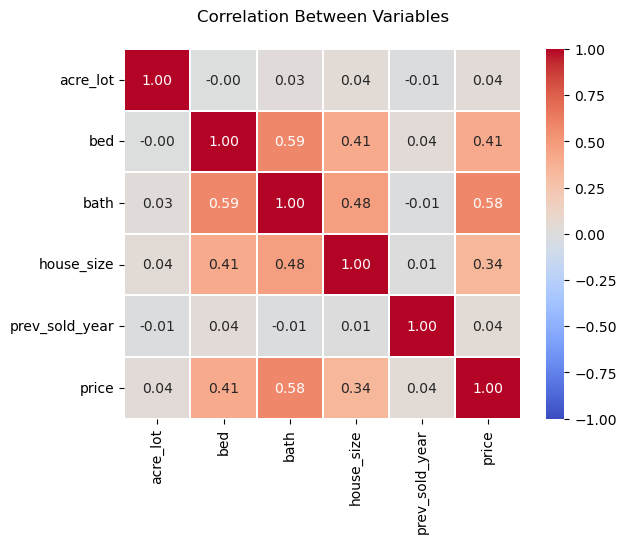

In [10]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

In [11]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


In [12]:
#features = ["latitude","longitude","bed","bath","house_size"]
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

In [13]:
X = normalize_df[savefeatures]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [14]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

In [15]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

In [16]:
adaboost_gscv = GridSearchCV(AdaBoostRegressor(random_state=0, n_estimators=100), {})
adaboost_gscv_model = adaboost_gscv.fit(X_train, y_train)
adaboost_predict = adaboost_gscv.predict(X_test)

In [17]:
results = print_more_stuff("Ada Boost Regressor", y_test, adaboost_predict, adaboost_gscv)
results_dict_append(results)

Ada Boost Regressor EVS = 0.486573085
Ada Boost Regressor MSE = 92,682,921,280.704941
Ada Boost Regressor MAE = 221,090.542697
Ada Boost Regressor R2 = 0.424090
Ada Boost Regressor Fit Time = 0.10334367752075195


In [18]:
gbr_gscv = GridSearchCV(GradientBoostingRegressor(random_state=0), {})
gbr_gscv_model = gbr_gscv.fit(X_train, y_train)
gbr_predict = gbr_gscv.predict(X_test)

In [19]:
results = print_more_stuff("Gradient Boosting Regressor", y_test, gbr_predict, gbr_gscv)
results_dict_append(results)

Gradient Boosting Regressor EVS = 0.609668179
Gradient Boosting Regressor MSE = 62,902,540,556.480034
Gradient Boosting Regressor MAE = 151,238.049432
Gradient Boosting Regressor R2 = 0.609138
Gradient Boosting Regressor Fit Time = 0.3662572860717773


In [20]:
rfr_gscv = GridSearchCV(RandomForestRegressor(max_depth=2, random_state=0), {})
rfr_gscv_model = rfr_gscv.fit(X_train, y_train)
rfr_predict = rfr_gscv.predict(X_test)

In [21]:
results = print_more_stuff("Random Forest Regressor", y_test, rfr_predict, rfr_gscv)
results_dict_append(results)

Random Forest Regressor EVS = 0.338288303
Random Forest Regressor MSE = 106,525,610,255.318359
Random Forest Regressor MAE = 209,799.706473
Random Forest Regressor R2 = 0.338074
Random Forest Regressor Fit Time = 0.21146941184997559


In [22]:
histgbr_gscv = GridSearchCV(HistGradientBoostingRegressor(), {})
histgbr_gscv_model = histgbr_gscv.fit(X_train, y_train)
histgbr_predict = histgbr_gscv.predict(X_test)

In [23]:
results = print_more_stuff("Hist Gradient Boosting Regressor", y_test, histgbr_predict, histgbr_gscv)
results_dict_append(results)

Hist Gradient Boosting Regressor EVS = 0.696329826
Hist Gradient Boosting Regressor MSE = 48,954,761,034.861160
Hist Gradient Boosting Regressor MAE = 130,167.210441
Hist Gradient Boosting Regressor R2 = 0.695806
Hist Gradient Boosting Regressor Fit Time = 0.6236058712005615


In [24]:
adaboost_predict_df = pd.DataFrame(adaboost_predict).reset_index()
adaboost_predict_df.rename(columns={0: "prediction"},inplace=True)

gbr_predict_df = pd.DataFrame(gbr_predict).reset_index()
gbr_predict_df.rename(columns={0: "prediction"},inplace=True)

rfr_predict_df = pd.DataFrame(rfr_predict).reset_index()
rfr_predict_df.rename(columns={0: "prediction"},inplace=True)

histgbr_predict_df = pd.DataFrame(histgbr_predict).reset_index()
histgbr_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

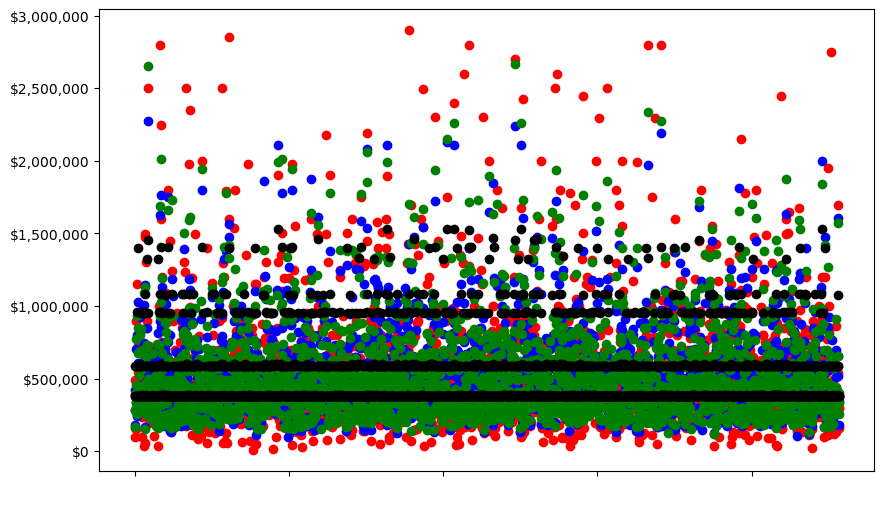

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(gbr_predict_df.index,gbr_predict_df["prediction"], color="blue")
plt.scatter(histgbr_predict_df.index,histgbr_predict_df["prediction"], color="green")
#plt.scatter(rfr_predict_df.index,adaboost_predict_df["prediction"], color="black")
#plt.scatter(rfr_predict_df.index,rfr_predict_df["prediction"], color="black")
plt.show()

In [26]:
results_dict

{'model': ['Ada Boost Regressor',
  'Gradient Boosting Regressor',
  'Random Forest Regressor',
  'Hist Gradient Boosting Regressor'],
 'explained variance score': ['0.486573085',
  '0.609668179',
  '0.338288303',
  '0.696329826'],
 'mae score': ['221,090.542697',
  '151,238.049432',
  '209,799.706473',
  '130,167.210441'],
 'mse score': ['92,682,921,280.704941',
  '62,902,540,556.480034',
  '106,525,610,255.318359',
  '48,954,761,034.861160'],
 'r2 score': ['0.424090', '0.609138', '0.338074', '0.695806'],
 'mean fit time': [0.10334367752075195,
  0.3662572860717773,
  0.21146941184997559,
  0.6236058712005615]}

In [27]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Ada Boost Regressor,0.486573085,"221,090.542697","92,682,921,280.704941",0.424090,0.103344
Gradient Boosting Regressor,0.609668179,"151,238.049432","62,902,540,556.480034",0.609138,0.366257
Random Forest Regressor,0.338288303,"209,799.706473","106,525,610,255.318359",0.338074,0.211469
Hist Gradient Boosting Regressor,0.696329826,"130,167.210441","48,954,761,034.861160",0.695806,0.623606
